In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
test_dir = "/content/drive/MyDrive/dataset-20250304T171709Z-001/dataset/test"
train_dir = "/content/drive/MyDrive/dataset-20250304T171709Z-001/dataset/train"

In [4]:
print("Train Directory:", train_dir)
print("Test Directory:", test_dir)

Train Directory: /content/drive/MyDrive/dataset-20250304T171709Z-001/dataset/train
Test Directory: /content/drive/MyDrive/dataset-20250304T171709Z-001/dataset/test


In [5]:
# Try a learning rate scheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
# Add reduce_lr to your callbacks list

In [7]:
from PIL import Image
import os

def convert_images_to_rgb(directory):
    for subdir, _, files in os.walk(directory):
        for file in files:
            path = os.path.join(subdir, file)
            try:
                img = Image.open(path)
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                    img.save(path)
            except Exception as e:
                print(f"Error processing {path}: {e}")



convert_images_to_rgb(train_dir)
convert_images_to_rgb(test_dir)


In [8]:
from PIL import Image
import os

def check_image_modes(directory):
    for subdir, _, files in os.walk(directory):
        for file in files:
            path = os.path.join(subdir, file)
            try:
                img = Image.open(path)
                print(f"{file}: {img.mode}")  # Print image mode
            except Exception as e:
                print(f"Error processing {file}: {e}")



print("Checking training images:")
check_image_modes(train_dir)

print("\nChecking validation images:")
check_image_modes(test_dir)


Streaming output truncated to the last 5000 lines.
images - 2025-02-10T003359.935.jpg: RGB
images - 2025-02-10T003411.455.jpg: RGB
images - 2025-02-09T123736.942.jpg: RGB
images - 2025-02-09T123723.859.jpg: RGB
images - 2025-02-09T123743.772.jpg: RGB
images - 2025-02-10T010552.669 - Copy.jpg: RGB
images - 2025-02-09T123736.159.jpg: RGB
images - 2025-02-09T123750.724.jpg: RGB
images - 2025-02-09T123703.399.jpg: RGB
images - 2025-02-09T123713.425.jpg: RGB
images - 2025-02-10T003422.240 - Copy.jpg: RGB
images - 2025-02-10T003407.504.jpg: RGB
images - 2025-02-09T123749.673.jpg: RGB
images - 2025-02-10T010543.639.jpg: RGB
images - 2025-02-10T010543.214 - Copy.jpg: RGB
images - 2025-02-09T123744.613.jpg: RGB
images - 2025-02-10T010543.639 - Copy.jpg: RGB
images - 2025-02-09T123728.765.jpg: RGB
images - 2025-02-10T010556.413.jpg: RGB
images - 2025-02-09T123728.225.jpg: RGB
images - 2025-02-09T123751.405.jpg: RGB
images - 2025-02-10T010554.581.jpg: RGB
images - 2025-02-09T123737.595.jpg: RGB
i

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [11]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [12]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 6694 images belonging to 8 classes.


In [16]:
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 1801 images belonging to 8 classes.


In [18]:
resnet = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [19]:
for layer in resnet.layers[:100]:
    layer.trainable = False

In [20]:
from tensorflow.keras.layers import BatchNormalization
x = Flatten()(resnet.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output_layer = Dense(train_data.num_classes, activation='softmax')(x)
model = Model(inputs=resnet.input, outputs=output_layer)

In [21]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True)

In [22]:
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

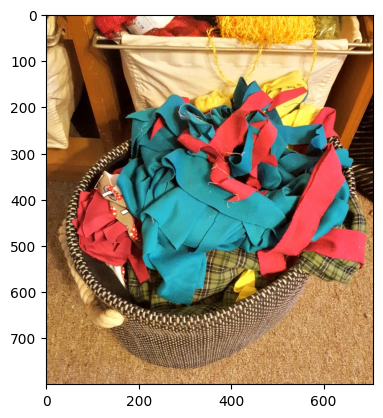

In [23]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('/content/drive/MyDrive/dataset-20250304T171709Z-001/dataset/train/Textile waste/01-knit-scraps.jpg')
plt.imshow(img)
plt.show()

In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=10,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


186/186 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 0.2011 - loss: 2.5833 - val_accuracy: 0.1901 - val_loss: 4.4021 - learning_rate: 5.0000e-04
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 163s 848ms/step - accuracy: 0.2269 - loss: 2.2526 - val_accuracy: 0.0749 - val_loss: 30.1853 - learning_rate: 5.0000e-04
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 160s 835ms/step - accuracy: 0.2606 - loss: 2.0704 - val_accuracy: 0.1221 - val_loss: 14.6371 - learning_rate: 5.0000e-04
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 184s 961ms/step - accuracy: 0.3044 - loss: 1.9019 - val_accuracy: 0.2582 - val_loss: 2.0652 - learning_rate: 5.0000e-04
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 185s 874ms/step - accuracy: 0.3306 - loss: 1.7845 - val_accuracy: 0.1353 - val_loss: 7.7814 - learning_rate: 5.0000e-04
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 196s 841ms/step - accuracy: 0.3461 - loss: 1.7401 - val_accuracy: 0.1353 - val_loss: 5.6615 - learning_rate: 5.0000e-04
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 212s 897ms/s

In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=5,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 176s 907ms/step - accuracy: 0.4288 - loss: 1.5057 - val_accuracy: 0.1471 - val_loss: 5.8568 - learning_rate: 5.0000e-04
Epoch 2/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 174s 901ms/step - accuracy: 0.4314 - loss: 1.5138 - val_accuracy: 0.2262 - val_loss: 2.8295 - learning_rate: 5.0000e-04
Epoch 3/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 189s 849ms/step - accuracy: 0.4353 - loss: 1.4937 - val_accuracy: 0.2006 - val_loss: 3.8497 - learning_rate: 5.0000e-04
Epoch 4/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 219s 938ms/step - accuracy: 0.4307 - loss: 1.5094 - val_accuracy: 0.2609 - val_loss: 3.9701 - learning_rate: 5.0000e-04
Epoch 5/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 185s 832ms/step - accuracy: 0.4558 - loss: 1.4425 - val_accuracy: 0.2595 - val_loss: 3.3948 - learning_rate: 5.0000e-04


In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=5,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.2281 - loss: 2.5421 - val_accuracy: 0.1228 - val_loss: 8.3907 - learning_rate: 5.0000e-04
Epoch 2/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 150s 802ms/step - accuracy: 0.2879 - loss: 2.0515 - val_accuracy: 0.0930 - val_loss: 20.9354 - learning_rate: 5.0000e-04
Epoch 3/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 150s 806ms/step - accuracy: 0.3146 - loss: 1.9257 - val_accuracy: 0.2873 - val_loss: 2.2107 - learning_rate: 5.0000e-04
Epoch 4/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 139s 746ms/step - accuracy: 0.3435 - loss: 1.8064 - val_accuracy: 0.1804 - val_loss: 3.3413 - learning_rate: 5.0000e-04
Epoch 5/5
186/186 ━━━━━━━━━━━━━━━━━━━━ 153s 804ms/step - accuracy: 0.3706 - loss: 1.7020 - val_accuracy: 0.3511 - val_loss: 1.7980 - learning_rate: 5.0000e-04


In [ ]:
model.save('/content/drive/MyDrive/best_model.keras')


In [24]:
from tensorflow import keras

model = keras.models.load_model('/content/drive/MyDrive/final_model.keras')


In [25]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 217,042,074 (827.95 MB)

 Trainable params: 70,968,584 (270.72 MB)

 Non-trainable params: 4,136,320 (15.78 MB)

 Optimizer params: 141,937,170 (541.45 MB)

In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=15,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 173s 933ms/step - accuracy: 0.3870 - loss: 1.6724 - val_accuracy: 0.3616 - val_loss: 1.7167 - learning_rate: 5.0000e-04
Epoch 2/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 139s 747ms/step - accuracy: 0.4154 - loss: 1.6072 - val_accuracy: 0.1797 - val_loss: 10.9987 - learning_rate: 5.0000e-04
Epoch 3/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 152s 818ms/step - accuracy: 0.4120 - loss: 1.5528 - val_accuracy: 0.3858 - val_loss: 1.6939 - learning_rate: 5.0000e-04
Epoch 4/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 138s 744ms/step - accuracy: 0.4118 - loss: 1.5804 - val_accuracy: 0.3449 - val_loss: 1.7657 - learning_rate: 5.0000e-04
Epoch 5/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 142s 761ms/step - accuracy: 0.4203 - loss: 1.5381 - val_accuracy: 0.1492 - val_loss: 5.4681 - learning_rate: 5.0000e-04
Epoch 6/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 138s 739ms/step - accuracy: 0.4147 - loss: 1.5175 - val_accuracy: 0.2172 - val_loss: 4.6117 - learning_rate: 5.0000e-04
Epoch 7/15
186/186 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 217,042,074 (827.95 MB)

 Trainable params: 70,968,584 (270.72 MB)

 Non-trainable params: 4,136,320 (15.78 MB)

 Optimizer params: 141,937,170 (541.45 MB)

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "/content/best_model.keras"

ModelCheckpoint(filepath=checkpoint_path, monitor="val_accuracy", save_best_only=True)

# checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, verbose=1)



In [20]:
print(ModelCheckpoint)

<class 'keras.src.callbacks.model_checkpoint.ModelCheckpoint'>


In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=20,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 148s 795ms/step - accuracy: 0.4817 - loss: 1.3562 - val_accuracy: 0.4393 - val_loss: 1.5563 - learning_rate: 1.0000e-04
Epoch 2/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 142s 760ms/step - accuracy: 0.4964 - loss: 1.3592 - val_accuracy: 0.2040 - val_loss: 4.6545 - learning_rate: 1.0000e-04
Epoch 3/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 146s 783ms/step - accuracy: 0.5002 - loss: 1.3326 - val_accuracy: 0.3942 - val_loss: 1.7015 - learning_rate: 1.0000e-04
Epoch 4/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 198s 761ms/step - accuracy: 0.4888 - loss: 1.3515 - val_accuracy: 0.4303 - val_loss: 1.6111 - learning_rate: 1.0000e-04
Epoch 5/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 140s 751ms/step - accuracy: 0.5086 - loss: 1.2922 - val_accuracy: 0.4795 - val_loss: 1.3338 - learning_rate: 2.0000e-05
Epoch 6/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 177s 950ms/step - accuracy: 0.5200 - loss: 1.2890 - val_accuracy: 0.5420 - val_loss: 1.2206 - learning_rate: 2.0000e-05
Epoch 7/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=10,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 141s 761ms/step - accuracy: 0.5365 - loss: 1.2319 - val_accuracy: 0.5559 - val_loss: 1.1802 - learning_rate: 1.0000e-05
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 144s 773ms/step - accuracy: 0.5260 - loss: 1.2546 - val_accuracy: 0.5746 - val_loss: 1.1494 - learning_rate: 1.0000e-05
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 142s 765ms/step - accuracy: 0.5342 - loss: 1.2262 - val_accuracy: 0.5635 - val_loss: 1.1588 - learning_rate: 1.0000e-05
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 141s 758ms/step - accuracy: 0.5421 - loss: 1.2161 - val_accuracy: 0.5802 - val_loss: 1.1268 - learning_rate: 1.0000e-05
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 139s 747ms/step - accuracy: 0.5419 - loss: 1.2058 - val_accuracy: 0.5621 - val_loss: 1.1578 - learning_rate: 1.0000e-05
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 138s 739ms/step - accuracy: 0.5285 - loss: 1.2260 - val_accuracy: 0.5788 - val_loss: 1.1383 - learning_rate: 1.0000e-05
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
model.save('/content/drive/MyDrive/final_model.keras')


In [ ]:
history.history['accuracy']

[0.5318143367767334,
 0.5355274081230164,
 0.5329957604408264,
 0.5375527143478394,
 0.5351898670196533,
 0.5329957604408264,
 0.5368776321411133,
 0.5375527143478394,
 0.5412658452987671,
 0.5407595038414001]

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "/content/drive/MyDrive/final_model.keras"

ModelCheckpoint(filepath=checkpoint_path, monitor="val_accuracy", save_best_only=True)

# checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, verbose=1)



In [26]:
from tensorflow import keras
model = keras.models.load_model(checkpoint_path)

In [27]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=25,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/25
210/210 ━━━━━━━━━━━━━━━━━━━━ 239s 993ms/step - accuracy: 0.5512 - loss: 1.2024 - val_accuracy: 0.6097 - val_loss: 1.0755 - learning_rate: 1.0000e-05
Epoch 2/25
210/210 ━━━━━━━━━━━━━━━━━━━━ 164s 779ms/step - accuracy: 0.5562 - loss: 1.1744 - val_accuracy: 0.5669 - val_loss: 1.1524 - learning_rate: 1.0000e-05
Epoch 3/25
210/210 ━━━━━━━━━━━━━━━━━━━━ 165s 787ms/step - accuracy: 0.5567 - loss: 1.1914 - val_accuracy: 0.5669 - val_loss: 1.1501 - learning_rate: 1.0000e-05
Epoch 4/25
210/210 ━━━━━━━━━━━━━━━━━━━━ 167s 795ms/step - accuracy: 0.5435 - loss: 1.2234 - val_accuracy: 0.5719 - val_loss: 1.1684 - learning_rate: 1.0000e-05
Epoch 5/25
210/210 ━━━━━━━━━━━━━━━━━━━━ 163s 778ms/step - accuracy: 0.5551 - loss: 1.2037 - val_accuracy: 0.5891 - val_loss: 1.1082 - learning_rate: 1.0000e-05
Epoch 6/25
210/210 ━━━━━━━━━━━━━━━━━━━━ 163s 777ms/step - accuracy: 0.5624 - loss: 1.1774 - val_accuracy: 0.5769 - val_loss: 1.1516 - learning_rate: 1.0000e-05
Epoch 7/25
210/210 ━━━━━━━━━━━━━━━━━━━━ 

In [28]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 289ms/step - accuracy: 0.6188 - loss: 1.0497
Test Accuracy: 62.02%


In [29]:
model = keras.models.load_model("/content/best_model.keras")

In [30]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 217,042,074 (827.95 MB)

 Trainable params: 70,968,584 (270.72 MB)

 Non-trainable params: 4,136,320 (15.78 MB)

 Optimizer params: 141,937,170 (541.45 MB)

In [32]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=25,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/25
210/210 ━━━━━━━━━━━━━━━━━━━━ 180s 857ms/step - accuracy: 0.5857 - loss: 1.1134 - val_accuracy: 0.6047 - val_loss: 1.0612 - learning_rate: 1.0000e-05
Epoch 2/25
210/210 ━━━━━━━━━━━━━━━━━━━━ 182s 763ms/step - accuracy: 0.5804 - loss: 1.1315 - val_accuracy: 0.6074 - val_loss: 1.0710 - learning_rate: 1.0000e-05
Epoch 3/25
210/210 ━━━━━━━━━━━━━━━━━━━━ 159s 759ms/step - accuracy: 0.5831 - loss: 1.1070 - val_accuracy: 0.6058 - val_loss: 1.0771 - learning_rate: 1.0000e-05
Epoch 4/25
210/210 ━━━━━━━━━━━━━━━━━━━━ 159s 755ms/step - accuracy: 0.5819 - loss: 1.1078 - val_accuracy: 0.5858 - val_loss: 1.1035 - learning_rate: 1.0000e-05
Epoch 5/25
210/210 ━━━━━━━━━━━━━━━━━━━━ 163s 775ms/step - accuracy: 0.5951 - loss: 1.1096 - val_accuracy: 0.6141 - val_loss: 1.0586 - learning_rate: 1.0000e-05
Epoch 6/25
210/210 ━━━━━━━━━━━━━━━━━━━━ 160s 760ms/step - accuracy: 0.5929 - loss: 1.0963 - val_accuracy: 0.5991 - val_loss: 1.0751 - learning_rate: 1.0000e-05
Epoch 7/25
210/210 ━━━━━━━━━━━━━━━━━━━━ 

In [33]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 290ms/step - accuracy: 0.6220 - loss: 0.9986
Test Accuracy: 63.24%


In [34]:
model.save('/content/drive/MyDrive/Final_Model.keras')
